In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import pandas as pd
from SED_fitting_prospect import get_agebins, adjust_agebins_with_zred
from plotting_Prospect import if_parametric_SFH
from prospect.io import read_results as reader
from prospect.plotting.corner import quantile
from astropy.coordinates import SkyCoord
import astropy.units as u

In [2]:
import sys
sys.path.append('../../photometry/code/')
import multibandphotometry as mbp

In [32]:
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.size'] = 20
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['axes.linewidth'] = 1

In [4]:
def load_results_list(version='homo_ellipse_v1_dered', SFH_models=['exponential', 'delayed', 'logM', 'continuity', 'dirichlet']):
    prepath = '/home/lupengjun/OII_emitter/SED_fitting/output/prospect_results/'
    out_list = []
    out_obs_list = []
    for SFH in SFH_models:
        hfile = prepath + f'{version}_{SFH}.h5'
        out, out_obs, out_model = reader.results_from(hfile)
        out_list.append(out)
        out_obs_list.append(out_obs)
    return out_list, out_obs_list
# out_list, out_obs_list = load_results_list()

In [5]:
def get_agediff(out):
    agebins = 10**[dic['init'] for dic in out['model_params'] if dic['name']=='agebins'][0]
    return agebins, np.diff(agebins).flatten()

In [6]:
def get_SFR_perbin(out, SFH):
    from prospect.models.transforms import zfrac_to_sfrac, zfrac_to_masses, logsfr_ratios_to_sfrs
    if SFH == 'logM':
        label_mask = np.array(['mass_' in label_ for label_ in out['theta_labels']])
        samples_masses = out['chain'][:, label_mask]
        return samples_masses/get_agediff(out)[1]
    elif SFH == 'continuity':
        agebins = get_agediff(out)[0]
        label_mask = np.array(['logsfr_ratios_' in label_ for label_ in out['theta_labels']])
        label_mask_ = np.array(['logmass' in label_ for label_ in out['theta_labels']])
        samples_sratios = out['chain'][:, label_mask]
        samples_logmass = out['chain'][:, label_mask_]
        samples_sfrs = np.asarray([logsfr_ratios_to_sfrs(samples_logmass[i], samples_sratios[i], np.log10(agebins)) for i in range(len(samples_sratios))])
        return samples_sfrs
    elif SFH == 'dirichlet':
        agebins = get_agediff(out)[0]
        label_mask = np.array(['z_fraction_' in label_ for label_ in out['theta_labels']])
        label_mask_ = np.array(['total_mass' in label_ for label_ in out['theta_labels']])
        samples_zfrac = out['chain'][:, label_mask]
        samples_total_mass = out['chain'][:, label_mask_]
        #samples_sfrac = np.asarray([zfrac_to_sfrac(samples_zfrac[i]) for i in range(len(samples_zfrac))])
        samples_masses = np.asarray([zfrac_to_masses(samples_total_mass[i], samples_zfrac[i], np.log10(agebins)) for i in range(len(samples_zfrac))])
        return samples_masses/get_agediff(out)[1]
    else:
        raise ValueError('SFH not recognized')

In [7]:
def plot_nonparam_SFH(ax, color, out, SFH, linestyle='-'):
    from prospect.plotting.sfh import sfh_quantiles
    nsamples = out['chain'].shape[0]
    weights = out['weights']
    agebins = 10**[dic['init'] for dic in out['model_params'] if dic['name']=='agebins'][0]
    tvec = np.unique(np.asarray(agebins).flatten())
    bins = np.tile(agebins, (nsamples, 1, 1))
    sfrs = get_SFR_perbin(out, SFH)
    sfh_quantiles_ = sfh_quantiles(tvec, bins, sfrs, weights=weights, q=[16, 50, 84])
    if ax:
        ax.step(tvec, sfh_quantiles_[:, 1], color=color, where='post', label=SFH, linestyle=linestyle)
        ax.fill_between(tvec, sfh_quantiles_[:, 0], sfh_quantiles_[:, 2], color=color, alpha=0.3, step='post')
        ax.set_xscale('log')
        ax.set_xlim(1e6, tvec.max())
    # print('tvec.max() =', tvec.max())
        return sfh_quantiles_
    else:
        return (tvec, sfh_quantiles_[:, 1])
    

In [8]:
def plot_param_SFH(ax, color, out, SFH, Gyrs, linestyle='-'):
    from prospect.plotting.sfh import params_to_sfh
    from plotting_Prospect import get_percentile
    label_mask_tau = np.array(['tau' in label_ for label_ in out['theta_labels']])
    label_mask_tage = np.array(['tage' in label_ for label_ in out['theta_labels']])
    label_mask_mass = np.array(['mass' in label_ for label_ in out['theta_labels']])
    samples_tau = out['chain'][:, label_mask_tau]
    samples_tage = out['chain'][:, label_mask_tage]
    samples_mass = out['chain'][:, label_mask_mass]
    params = dict(tage=samples_tage, tau=samples_tau, mass=samples_mass)
    if SFH == 'exponential':
        params['sfh'] = 1
    elif SFH == 'delayed':
        params['sfh'] = 4
    else:
        raise ValueError('SFH not recognized') 
    tvec, sfrs, _ = params_to_sfh(params, time=Gyrs) #sfrs in (nsampels, nvar)
    sfrs = sfrs.T #sfrs in (nvar, nsamples)
    sfh_quantiles = quantile(sfrs, q=np.atleast_1d([0.16, 0.5, 0.84]), weights=out['weights'])
    if ax:
        ax.plot(tvec*1e9, sfh_quantiles[:, 1], color=color, label=SFH, linestyle=linestyle)
        ax.fill_between(tvec*1e9, sfh_quantiles[:, 0], sfh_quantiles[:, 2], color=color, alpha=0.3)
        ax.set_xscale('log')
        ax.set_xlim(1e6, 1e9)
        return sfh_quantiles
    else:
        return (tvec*1e9, sfh_quantiles[:, 1])
    

In [9]:
def wavelength_to_Hz(waves):
    '''
    wavelength in Angstrom
    '''
    return 3e18 / waves

# SED fitting plot with residuals

In [10]:
hfile = '/home/lupengjun/OII_emitter/SED_fitting/output/prospect_results/homo_ellipse_v1_dered_logM.h5'
out, out_obs, out_model = reader.results_from(hfile)

:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=[100000. 100000. 100000. 100000. 100000. 100000. 100000. 100000.],maxi=[1.e+11 1.e+11 1.e+11 1.e+11 1.e+11 1.e+11 1.e+11 1.e+11])
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.6)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=6.0)
  gas_logu: <class 'prospect.models.priors.TopHat'>(mini=-5.0,maxi=-1.0)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.924] 
  sfh: [3] 
  imf_type: [2] 
  dust_type: [2] 
  agebins: [[0.         6.65395102]
 [6.65395102 7.13107228]
 [7.13107228 7.65395102]
 [7.65395102 8.17246496]
 [8.17246496 8.69534371]
 [8.69534371 9.21025352]
 [9.21025352 9.72213688]
 [9.72213688 9.79067159]] 
  total_mass: [1.e+10] <function total_mass at 0x7fd50ff86320>
  add_neb_emission: [ True] 
  add_neb_continuum: [ True] 
  nebemlineinspec: [ True] 
  gas_logz: [0.] 

In [12]:
galaxy_SED = [out['bestfit']['restframe_wavelengths']*1.924, out['bestfit']['spectrum']]
galaxy_SED = np.array(galaxy_SED)

In [5]:
out['bestfit']['parameter']

array([ 4.35234941e+08,  1.13808802e+08,  1.72227586e+09,  2.41659527e+10,
        3.65690869e+05,  5.02654716e+09,  2.51779872e+06,  6.82867901e+10,
        5.97857369e-01,  2.41441793e+00, -3.25743661e+00])

In [5]:
sps = reader.get_sps(out)

In [6]:
sps.get_galaxy_spectrum(**out_model.params)

(array([9.100e+01, 9.400e+01, 9.600e+01, ..., 9.817e+07, 9.908e+07,
        1.000e+08]),
 array([1.25000000e-78, 1.25000000e-78, 1.25000000e-78, ...,
        1.31484444e-14, 1.31559578e-14, 1.31596415e-14]),
 0.7750310183548449)

In [11]:
out_model.params

{'zred': array([0.924]),
 'mass': array([10000000., 10000000., 10000000., 10000000., 10000000., 10000000.,
        10000000., 10000000.]),
 'logzsol': array([-0.5]),
 'dust2': array([0.6]),
 'sfh': array([3]),
 'imf_type': array([2]),
 'dust_type': array([2]),
 'agebins': array([[0.        , 6.65395102],
        [6.65395102, 7.13107228],
        [7.13107228, 7.65395102],
        [7.65395102, 8.17246496],
        [8.17246496, 8.69534371],
        [8.69534371, 9.21025352],
        [9.21025352, 9.72213688],
        [9.72213688, 9.79067159]]),
 'total_mass': array([1.e+10]),
 'add_neb_emission': array([ True]),
 'add_neb_continuum': array([ True]),
 'nebemlineinspec': array([ True]),
 'gas_logz': array([0.]),
 'gas_logu': array([-2.])}

In [16]:
len(out['theta_labels'])

11

In [29]:
out_model.set_parameters(out['bestfit']['parameter'])
specwaves, continuum, _ = sps.get_galaxy_spectrum(**out_model.params)

In [32]:
out_model.predict(out['bestfit']['parameter'], obs=out_obs, sps=sps)
out_model.predict_eline_spec()

AttributeError: 'SpecModel' object has no attribute '_eline_sigma_kms'

In [12]:
linewaves, linespec = sps.get_galaxy_elines()

In [10]:
allwaves, allspec = out['bestfit']['restframe_wavelengths'], out['bestfit']['spectrum']

In [14]:
norm = allspec.max()/continuum.max()

In [15]:
specwaves.shape, allwaves.shape

((5994,), (5994,))

(1000.0, 400000.0)

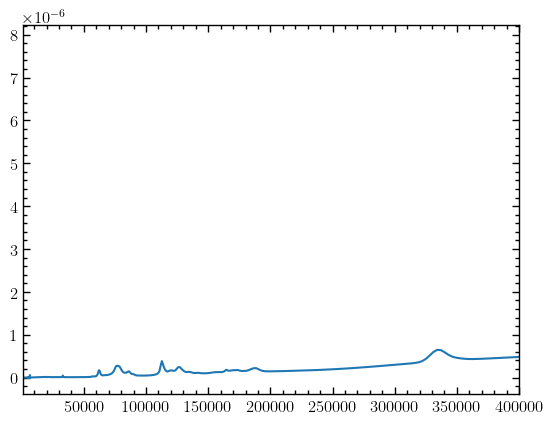

In [24]:
plt.plot(specwaves, continuum*norm)
# plt.plot(allwaves, allspec)
# plt.plot(linewaves, linespec)
plt.xlim(1e3, 4e5)

(1000.0, 400000.0)

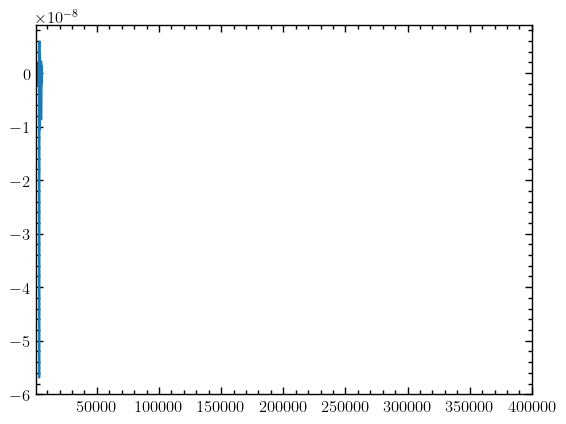

In [25]:
plt.plot(allspec-continuum*norm)
plt.xlim(1e3, 4e5)

In [13]:
np.savetxt('galaxy_SED.txt', galaxy_SED)

In [15]:
waves, spectrum = np.loadtxt('galaxy_SED.txt')

In [4]:
bsed = out["bestfit"]

['logzsol',
 'dust2',
 'logmass',
 'logsfr_ratios_1',
 'logsfr_ratios_2',
 'logsfr_ratios_3',
 'logsfr_ratios_4',
 'logsfr_ratios_5',
 'logsfr_ratios_6',
 'logsfr_ratios_7',
 'gas_logu']

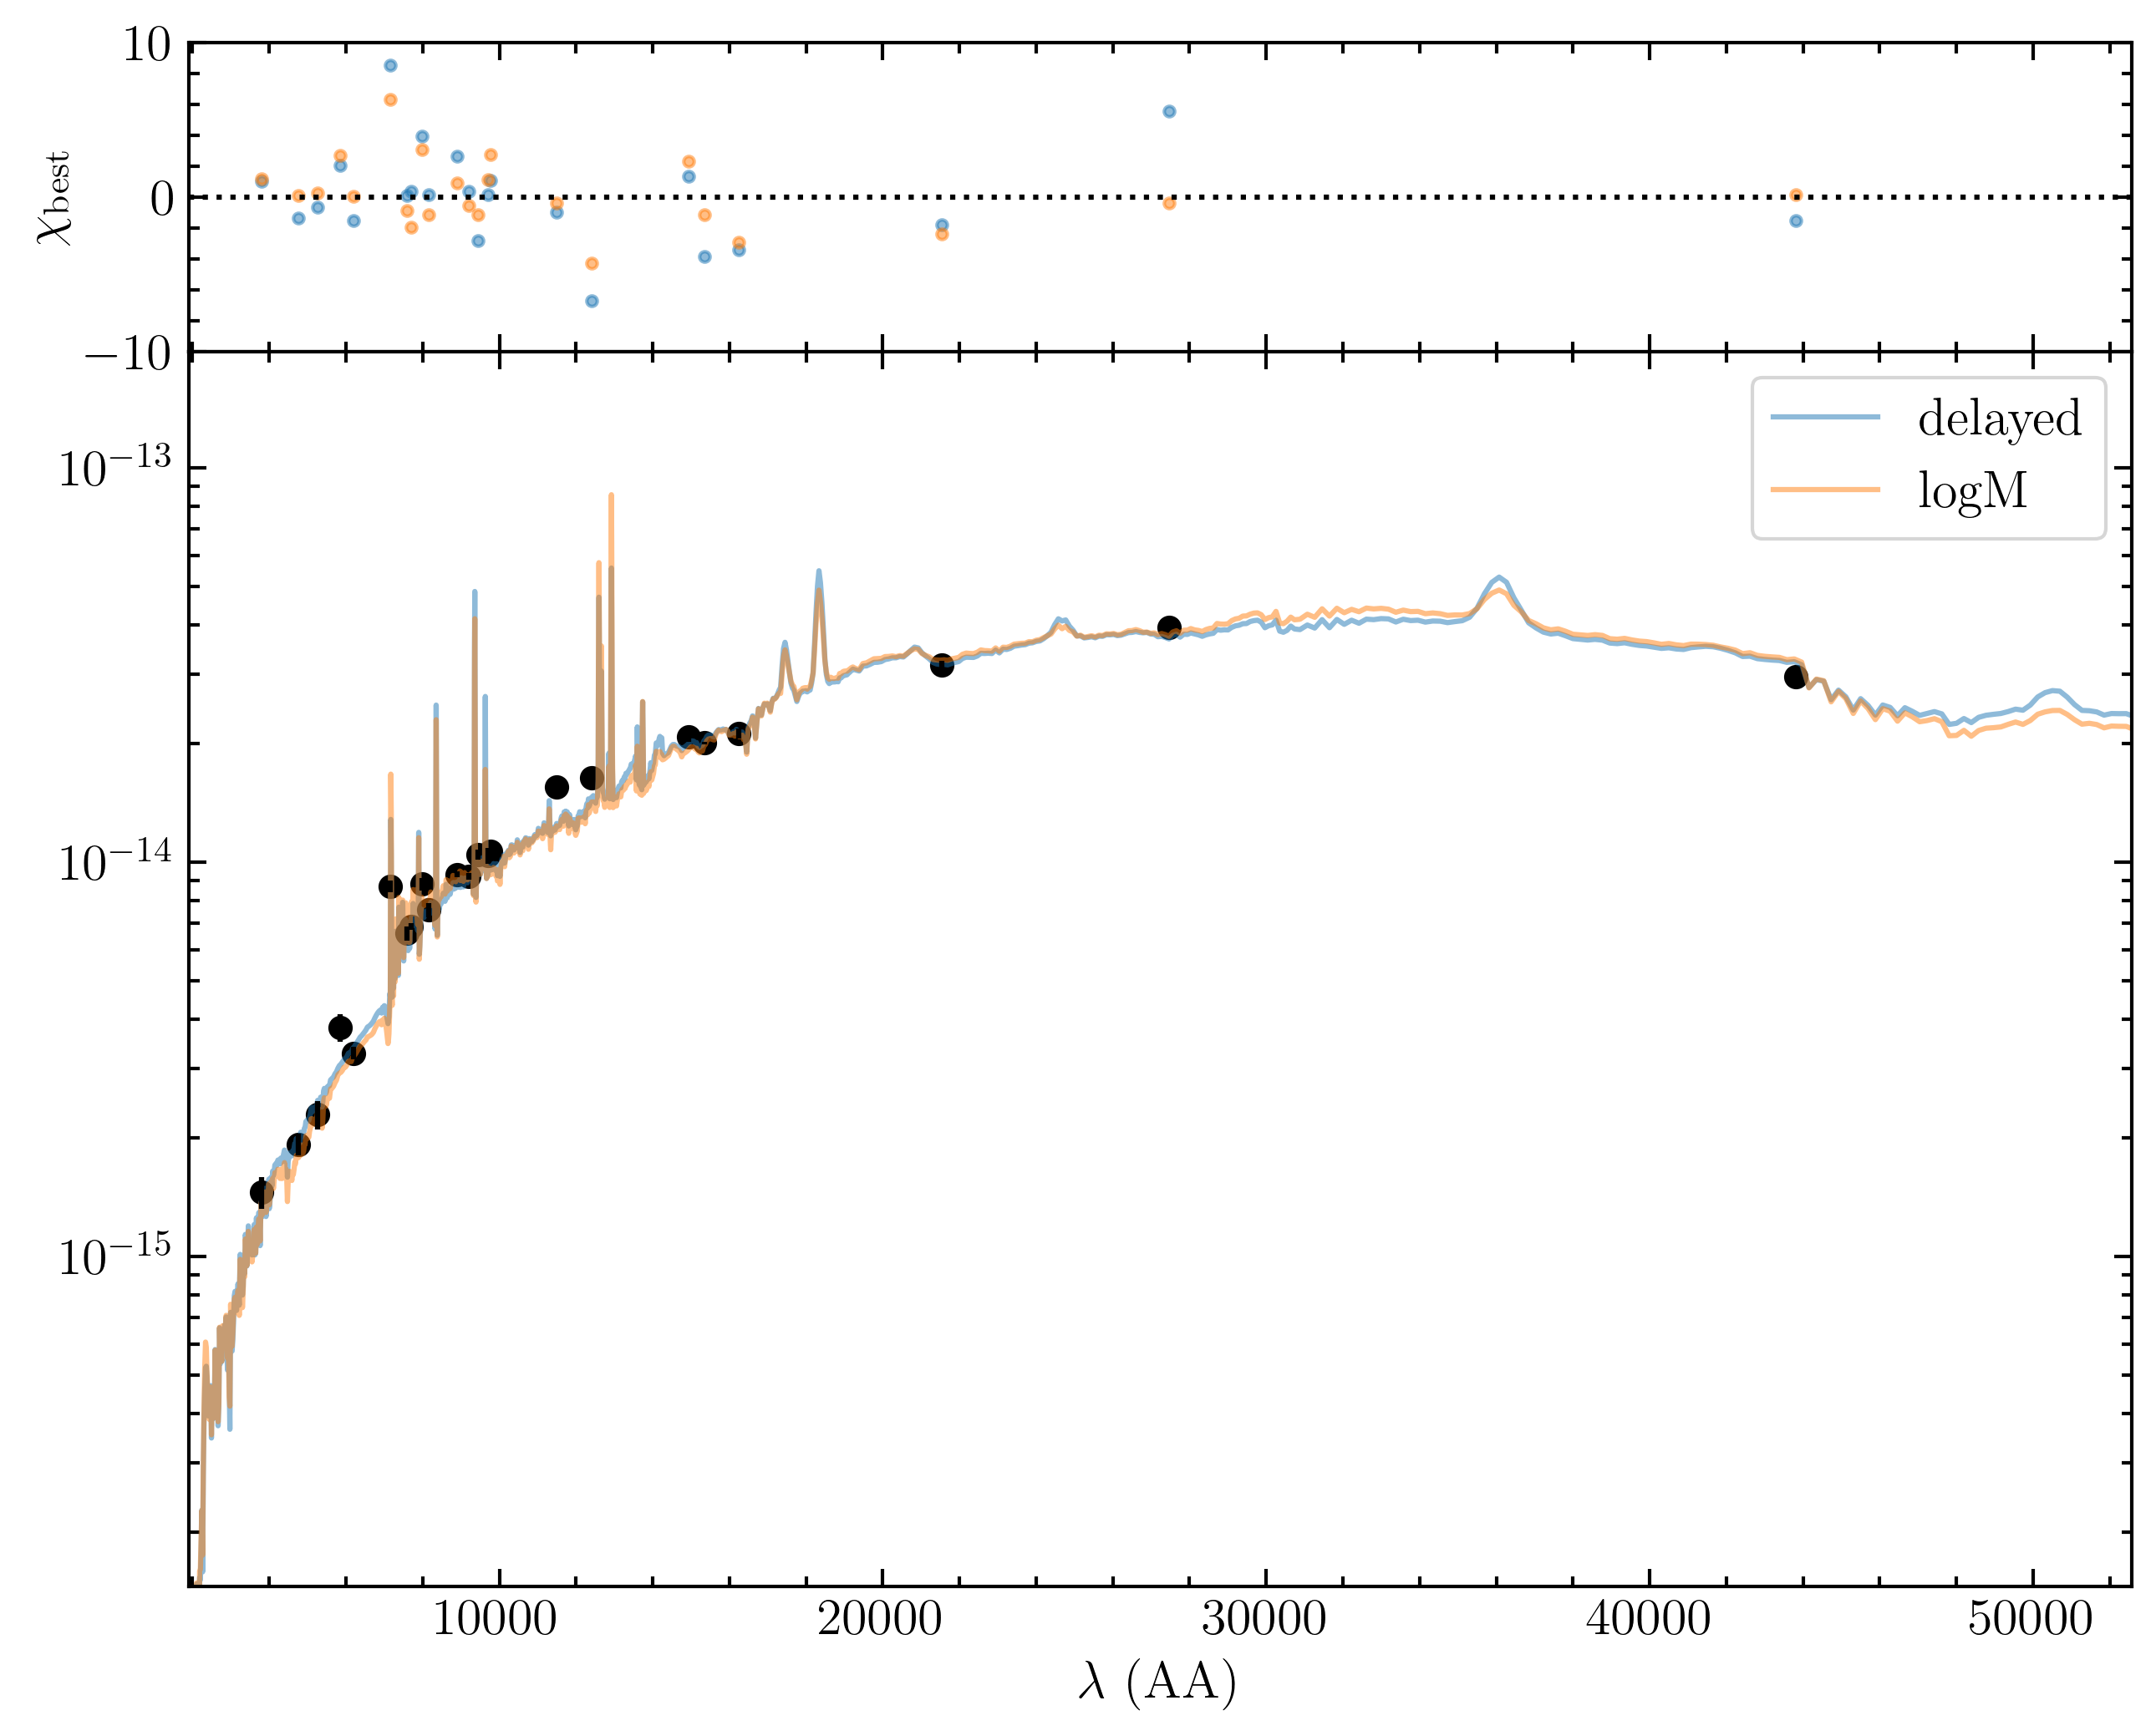

In [18]:
sfig, saxes = plt.subplots(2, 1, gridspec_kw=dict(height_ratios=[1, 4]), sharex=True, figsize=(10, 8))
ax = saxes[1]
ax_ = saxes[0]
out_obs = out_obs_list[0]
pwave = np.array([f.wave_effective for f in out_obs["filters"]])
pfreq = wavelength_to_Hz(pwave)

ax.plot(pwave, out_obs["maggies"]*3631*pfreq*1e-23, linestyle="", marker="o", color="k")
ax.errorbar(pwave,  out_obs["maggies"]*3631*pfreq*1e-23, out_obs["maggies_unc"]*3631*pfreq*1e-23, linestyle="", color="k", zorder=10)
# ax.set_ylabel(r'$\lambda f_\lambda (\rm{erg~cm^{-2}s^{-1}})$')
ax.set_xlabel(r"$\lambda$ (AA)")
ax.set_xlim(0.5*pwave.min(), 1.2*pwave.max())
ax.set_ylim((out_obs["maggies"]*3631*pfreq*1e-23).min()* 0.1, (out_obs["maggies"]*3631*pfreq*1e-23).max() * 5)
ax.set_yscale("log")
# ax.set_xscale("log")
for icolor, out in enumerate(out_list):
    out_obs = out_obs_list[icolor]
    SFH = SFH_models[icolor]
    bsed = out["bestfit"]
    bsed_freq = wavelength_to_Hz(bsed["restframe_wavelengths"] * (1+out_obs["redshift"]))
    ax.plot(bsed["restframe_wavelengths"] * (1+out_obs["redshift"]), bsed["spectrum"]*3631*bsed_freq*1e-23, color=color_list[icolor], label=SFH, alpha=0.5)
    chi = (out_obs["maggies"] - bsed["photometry"]) / out_obs["maggies_unc"]
    ax_.plot(np.sort(pwave), chi[np.argsort(pwave)], marker='.', linestyle="", color=color_list[icolor], alpha=0.5)
ax_.axhline(0, color="k", linestyle=":")
ax_.set_ylim(-10, 10)
ax_.set_ylabel(r"$\chi_{\rm best}$")

plt.legend(loc='upper right')
plt.subplots_adjust(hspace=0.)

In [23]:
# sfig, saxes = plt.subplots(2, 1, gridspec_kw=dict(height_ratios=[1, 4]), sharex=True, figsize=(10, 8))
def plot_SEDs(saxes, out_list, out_obs_list, SFH_models, color_list, linestyle='-', dotstyle='.', marker='o'):
    ax = saxes[1]
    ax_ = saxes[0]
    out_obs = out_obs_list[0]
    pwave = np.array([f.wave_effective for f in out_obs["filters"]])
    pfreq = wavelength_to_Hz(pwave)
    # ax.plot(pwave, out_obs["maggies"]*3631*pfreq*1e-23, linestyle="", marker="o", color="k")
    # ax.errorbar(pwave,  out_obs["maggies"]*3631*pfreq*1e-23, out_obs["maggies_unc"]*3631*pfreq*1e-23, linestyle="", color="k", zorder=10)
    ax.set_ylabel(r'$\lambda F_\lambda (\rm{erg~s^{-1}~cm^{-2}})$')
    ax.set_xlabel(r"Observed Wavelength $\lambda~\rm{(\mu m)}$")
    ax.set_xlim(0.5*pwave.min()*1e-4, 1.2*pwave.max()*1e-4)
    ax.set_ylim((out_obs["maggies"]*3631*pfreq*1e-23).min()* 0.1, (out_obs["maggies"]*3631*pfreq*1e-23).max() * 5)
    ax.set_yscale("log")
    # SED spectra plotting
    linelist = []
    for icolor, out in enumerate(out_list):
        out_obs = out_obs_list[icolor]
        SFH = SFH_models[icolor]
        bsed = out["bestfit"]
        bsed_freq = wavelength_to_Hz(bsed["restframe_wavelengths"] * (1+out_obs["redshift"]))
        #plot spetra lines
        line, = ax.plot(bsed["restframe_wavelengths"]*(1+out_obs["redshift"])*1e-4, bsed["spectrum"]*3631*bsed_freq*1e-23, color=color_list[icolor], linestyle=linestyle, label=SFH)
        linelist.append(line)
        #plot chi dots
        chi = (out_obs["maggies"] - bsed["photometry"]) / out_obs["maggies_unc"]
        ax_.plot(np.sort(pwave)*1e-4, chi[np.argsort(pwave)], marker=dotstyle, linestyle="", color=color_list[icolor])
    #set color list
    colorlist = list(mcolors.BASE_COLORS.keys())
    colorlist.reverse()
    #photometry plotting
    telelist = []
    for iobs, filter in enumerate(out_obs["filters"]):
        telescope = filter.name.split('/')[-2]
        if telescope not in telelist:
            telelist.append(telescope)
            color = colorlist.pop()
        ax.plot(pwave[iobs]*1e-4, out_obs["maggies"][iobs]*3631*pfreq[iobs]*1e-23, linestyle="", marker=marker, color=color)
        ax.errorbar(pwave[iobs]*1e-4, out_obs["maggies"][iobs]*3631*pfreq[iobs]*1e-23, out_obs["maggies_unc"][iobs]*3631*pfreq[iobs]*1e-23, linestyle="", color=color, zorder=10)
    ax_.axhline(0, color="k", linestyle=":")
    ax_.set_ylim(-10, 10)
    ax_.set_ylabel(r"Residuals")
    SFH_legend = ax.legend(handles=linelist, loc='upper right', fontsize=15)
    return SFH_legend

In [21]:
# sfig, saxes = plt.subplots(2, 1, gridspec_kw=dict(height_ratios=[1, 4]), sharex=True, figsize=(10, 8))
def plot_single_telescope_SEDs(saxes, out_list, out_obs_list, SFH_models, color_list, telescope='SUBARU'):
    ax = saxes[1]
    ax_ = saxes[0]
    out_obs = out_obs_list[0]
    pwave = np.array([f.wave_effective for f in out_obs["filters"]])
    pfreq = wavelength_to_Hz(pwave)

    # ax.plot(pwave, out_obs["maggies"]*3631*pfreq*1e-23, linestyle="", marker="o", color="k")
    # ax.errorbar(pwave,  out_obs["maggies"]*3631*pfreq*1e-23, out_obs["maggies_unc"]*3631*pfreq*1e-23, linestyle="", color="k", zorder=10)
    ax.set_ylabel(r'$\lambda f_\lambda (\rm{erg~cm^{-2}s^{-1}})$')
    ax.set_xlabel(r"$\lambda$ (AA)")
    ax.set_xlim(0.5*pwave.min(), 1.2*pwave.max())
    # SED spectra plotting
    linelist = []
    for icolor, out in enumerate(out_list):
        out_obs = out_obs_list[icolor]
        SFH = SFH_models[icolor]
        bsed = out["bestfit"]
        bsed_freq = wavelength_to_Hz(bsed["restframe_wavelengths"] * (1+out_obs["redshift"]))
        line, = ax.plot(bsed["restframe_wavelengths"] * (1+out_obs["redshift"]), bsed["spectrum"]*3631*bsed_freq*1e-23, color=color_list[icolor], label=SFH)
        linelist.append(line)
        chi = (out_obs["maggies"] - bsed["photometry"]) / out_obs["maggies_unc"]
        ax_.plot(np.sort(pwave), chi[np.argsort(pwave)], marker='.', linestyle="", color=color_list[icolor])
    for iobs, filter in enumerate(out_obs["filters"]):
        telescope_ = filter.name.split('/')[-2]
        print(telescope_)
        if telescope_ == telescope:
            print('y')
            ax.plot(filter.wave_effective, out_obs["maggies"][iobs]*3631*pfreq[iobs]*1e-23, linestyle="", marker="o", color="k")
    ax.set_ylim((out_obs["maggies"]*3631*pfreq*1e-23).min()* 0.1, (out_obs["maggies"]*3631*pfreq*1e-23).max() * 5)
    ax.set_yscale("log")
    ax_.axhline(0, color="k", linestyle=":")
    ax_.set_ylim(-10, 10)
    ax_.set_ylabel(r"$\chi_{\rm best}$")
    SFH_legend = ax.legend(handles=linelist, loc='upper right', fontsize=15)
    return SFH_legend

:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=10.0,maxi=1000000000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.6)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=6.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.1,maxi=13.8)
  tau: <class 'prospect.models.priors.TopHat'>(mini=0.3,maxi=10.0)
  gas_logu: <class 'prospect.models.priors.TopHat'>(mini=-5.0,maxi=-1.0)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.924] 
  sfh: [4] 
  imf_type: [2] 
  dust_type: [2] 
  add_neb_emission: [ True] 
  add_neb_continuum: [ True] 
  nebemlineinspec: [ True] 
  gas_logz: [0.] <function stellar_logzsol at 0x7ff5c29a63b0>
:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=[100000. 100000. 100000. 100000. 100000. 

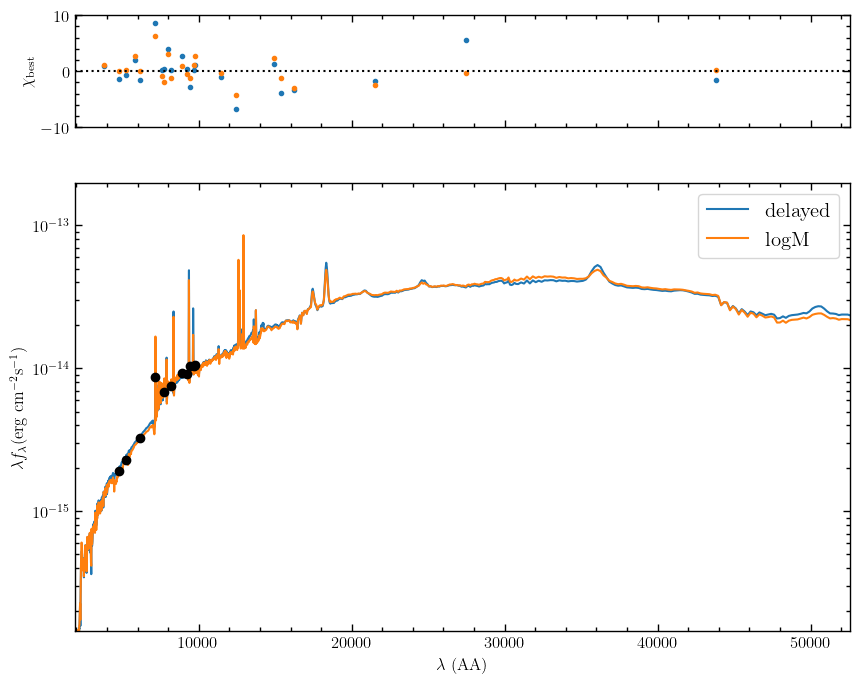

In [21]:
out_list, out_obs_list = load_results_list('homo_ellipse_v1_dered', ['delayed', 'logM'])
sfig, saxes = plt.subplots(2, 1, gridspec_kw=dict(height_ratios=[1, 4]), sharex=True, figsize=(10, 8))
plot_single_telescope_SEDs(saxes, out_list, out_obs_list, ['delayed', 'logM'], color_list, telescope='SUBARU')

# SFH

In [12]:
color_list = list(mcolors.TABLEAU_COLORS.keys())
out_list, out_obs_list = load_results_list('homo_ellipse_v1_dered', ['delayed', 'logM'])

:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=10.0,maxi=1000000000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.6)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=6.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.1,maxi=13.8)
  tau: <class 'prospect.models.priors.TopHat'>(mini=0.3,maxi=10.0)
  gas_logu: <class 'prospect.models.priors.TopHat'>(mini=-5.0,maxi=-1.0)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.924] 
  sfh: [4] 
  imf_type: [2] 
  dust_type: [2] 
  add_neb_emission: [ True] 
  add_neb_continuum: [ True] 
  nebemlineinspec: [ True] 
  gas_logz: [0.] <function stellar_logzsol at 0x7f41856aa170>
:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=[100000. 100000. 100000. 100000. 100000. 

In [46]:
#delayed
ts, sfrs = plot_param_SFH(ax=None, color=None, out=out_list[0], SFH='delayed', Gyrs=np.logspace(0, 10, 30)/1e9)
ts, sfrs

(array([1.00000000e+00, 2.21221629e+00, 4.89390092e+00, 1.08263673e+01,
        2.39502662e+01, 5.29831691e+01, 1.17210230e+02, 2.59294380e+02,
        5.73615251e+02, 1.26896100e+03, 2.80721620e+03, 6.21016942e+03,
        1.37382380e+04, 3.03919538e+04, 6.72335754e+04, 1.48735211e+05,
        3.29034456e+05, 7.27895384e+05, 1.61026203e+06, 3.56224789e+06,
        7.88046282e+06, 1.74332882e+07, 3.85662042e+07, 8.53167852e+07,
        1.88739182e+08, 4.17531894e+08, 9.23670857e+08, 2.04335972e+09,
        4.52035366e+09, 1.00000000e+10]),
 array([144.3179499 , 144.31794972, 144.31794931, 144.31794841,
        144.31794642, 144.31794201, 144.31793226, 144.3179107 ,
        144.317863  , 144.31775747, 144.31752363, 144.31691735,
        144.31532098, 144.31262771, 144.30622704, 144.29175456,
        144.26043671, 144.19547107, 144.0412504 , 143.69579514,
        142.90032052, 140.94358207, 135.56741968, 120.38789676,
         57.69288012,   0.        ,   0.        ,   0.        ,
      

In [47]:
ts_interp = np.logspace(0, 8, 10) #consider star formation less than 100 Myrs
sfrs_interp = np.interp(x=ts_interp, xp=ts, fp=sfrs, left=0, right=0, period=None)
ts_interp, sfrs_interp

(array([1.00000000e+00, 7.74263683e+00, 5.99484250e+01, 4.64158883e+02,
        3.59381366e+03, 2.78255940e+04, 2.15443469e+05, 1.66810054e+06,
        1.29154967e+07, 1.00000000e+08]),
 array([144.3179499 , 144.31794888, 144.31794096, 144.31787961,
        144.31738349, 144.31304275, 144.28016738, 144.03101436,
        141.86897703, 111.48688092]))

In [48]:
sf_mass_delayed = np.trapz(y=sfrs_interp, x=ts_interp)
sf_mass_delayed

12879996537.517635

In [34]:
#logM
ts, sfrs = plot_nonparam_SFH(ax=None, color=None, out=out_list[1], SFH='logM')
ts_diff = np.diff(ts)
ts, sfrs, ts_diff

(array([1.00000000e+00, 4.50765865e+06, 1.35229760e+07, 4.50765865e+07,
        1.48752735e+08, 4.95842452e+08, 1.62275711e+09, 5.27396062e+09,
        6.17549235e+09]),
 array([9.62710498e+01, 2.06035373e+01, 4.49119119e+01, 2.41848576e+02,
        2.37629655e-03, 7.61423256e+00, 9.38917461e-01, 4.59896994e+01,
        4.59896994e+01]),
 array([4.50765765e+06, 9.01531730e+06, 3.15536106e+07, 1.03676149e+08,
        3.47089716e+08, 1.12691466e+09, 3.65120351e+09, 9.01531730e+08]))

In [41]:
ts_ = ts[ts<1e8] #less than 100Myrs
ts0 = ts_[:-1] #full sum
ts_diff0 = ts_diff[:len(ts0)]
sf_mass0 = np.sum(sfrs[:len(ts0)]*ts_diff0)
ts_diff1 = 1e8 - ts_[-1]
sf_mass1 = sfrs[len(ts0)]*ts_diff1
sf_mass_logM = sf_mass0 + sf_mass1
# ts0, ts_diff0, ts_diff1, sf_mass0, sf_mass1
sf_mass_logM

15319986707.33703

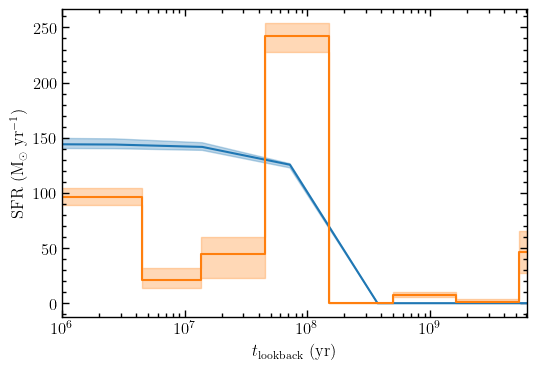

In [15]:
SFH_models = ['delayed', 'logM']
# fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for i, (out, SFH) in enumerate(zip(out_list, SFH_models)):
    color = color_list[i]
    # if SFH == 'continuity': plot_nonparam_SFH(ax, color, out, SFH)
    if if_parametric_SFH(SFH):
        ts, sfrs = plot_param_SFH(ax=None, color, out, SFH, np.logspace(0, 10, 15)/1e9)
    else:
        ts, sfrs = plot_nonparam_SFH(ax=None, color, out, SFH)
    # ax.set_ylabel(r'$\rm{SFR}~(M_\odot~\rm{yr}^{-1})$')
    # ax.set_xlabel(r'$t_{\rm{lookback}}~(\rm{yr})$')

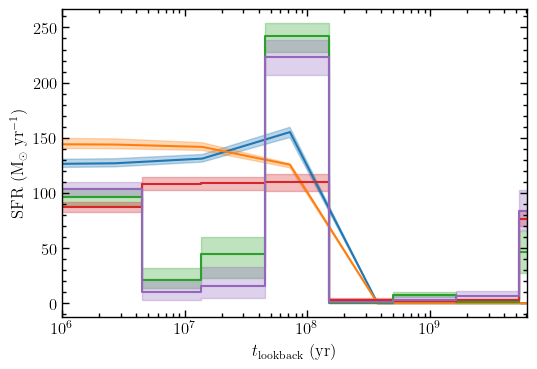

In [19]:
SFH_models = ['exponential', 'delayed', 'logM', 'continuity', 'dirichlet']
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for i, (out, SFH) in enumerate(zip(out_list, SFH_models)):
    color = color_list[i]
    # if SFH == 'continuity': plot_nonparam_SFH(ax, color, out, SFH)
    if if_parametric_SFH(SFH):
        sfrs_quantiles = plot_param_SFH(ax, color, out, SFH, np.logspace(0, 10, 15)/1e9)
    else:
        plot_nonparam_SFH(ax, color, out, SFH)
    ax.set_ylabel(r'$\rm{SFR}~(M_\odot~\rm{yr}^{-1})$')
    ax.set_xlabel(r'$t_{\rm{lookback}}~(\rm{yr})$')

In [35]:
def plot_SFHs(ax, out_list, SFH_models, color_list, linestyle='-'):
    for i, (out, SFH) in enumerate(zip(out_list, SFH_models)):
        color = color_list[i]
        if if_parametric_SFH(SFH):
            sfrs_quantiles = plot_param_SFH(ax, color, out, SFH, np.logspace(0, 10, 15)/1e9, linestyle=linestyle)
        else:
            plot_nonparam_SFH(ax, color, out, SFH, linestyle=linestyle)
    ax.set_ylabel(r'$\rm{SFR}~(M_\odot~\rm{yr}^{-1})$')
    ax.set_xlabel(r'Lookback Time (yr)')
    # ax.set_ylim(-5, 100)

# SED fitting results

In [14]:
def axes_frac_to_loc(xmin, xmax, xfrac):
    return xmin + xfrac * (xmax - xmin)
def axes_frac_to_loc_logscale(xmin, xmax, xfrac):
    # Convert xmin and xmax to logarithmic scale
    log_xmin = np.log10(xmin)
    log_xmax = np.log10(xmax)
    # Compute the position in logarithmic scale
    log_x = log_xmin + xfrac * (log_xmax - log_xmin)
    # Convert back to the original scale
    return 10**log_x

In [15]:
def add_filter_curves(ax, out_obs, uplim):
    colorlist = list(mcolors.BASE_COLORS.keys())
    colorlist.reverse()
    telelist = []
    linelist = []
    for filter in out_obs['filters']:
        telescope = filter.name.split('/')[-2]
        waves, transmisson = filter.wavelength, filter.transmission
        transmisson = transmisson / transmisson.max() * uplim        
        if telescope not in telelist:
            color = colorlist.pop()
            telelist.append(telescope)
            line, = ax.plot(waves*1e-4, transmisson, color=color, label=telescope)
            linelist.append(line)
        else:
            ax.plot(waves*1e-4, transmisson, color=color, label=telescope)
    ax.legend(handles=linelist, loc='lower right', fontsize=12)
    return ax

In [16]:
def plot_SED_with_SFHs(version, SFH_models, color_list, linestyle='-', dotstyle='.', marker='o', display_results=True, axes=(None, None, None), locs=None, add_filter_curve=True, display_legend=True):
    out_list, out_obs_list = load_results_list(version, SFH_models)
    if axes[0] is None and axes[1] is None:
        sfig, saxes = plt.subplots(2, 1, gridspec_kw=dict(height_ratios=[1, 4]), sharex=True, figsize=(10, 8))
    else:
        sfig, saxes = axes[0], axes[1]
    SFH_legend = plot_SEDs(saxes, out_list, out_obs_list, SFH_models, color_list, linestyle=linestyle, dotstyle=dotstyle, marker=marker)
    plt.subplots_adjust(hspace=0.)
    x, y = 0.48, 0.08
    width, height = 0.4, 0.3
    xmin, xmax = saxes[-1].get_xlim()
    ymin, ymax = saxes[-1].get_ylim()
    if axes[2] is None:
        subax = sfig.add_axes([x,0.3,width,0.2])
    else:
        subax = axes[2]
    plot_SFHs(subax, out_list, SFH_models, color_list, linestyle=linestyle)
    if 'delayed' in SFH_models and 'logM' in SFH_models and display_results:
        results_df = pd.read_excel('SED_results_prospect.xlsx', sheet_name=version, index_col=0)
        delayed_SFR_down, delayed_SFR, delayed_SFR_up= eval(results_df['SFR']['delayed'])
        logM_SFR_down, logM_SFR, logM_SFR_up = eval(results_df['SFR']['logM'])
        delayed_mass_down, delayed_mass, delayed_mass_up = eval(results_df['surviving_mass']['delayed'])
        logM_mass_down, logM_mass, logM_mass_up = eval(results_df['surviving_mass']['logM'])
        delayed_SFR_err = (-delayed_SFR_down+delayed_SFR_up)/2
        logM_SFR_err = (-logM_SFR_down+logM_SFR_up)/2
        delayed_mass_err = (-delayed_mass_down+delayed_mass_up)/2
        logM_mass_err = (-logM_mass_down+logM_mass_up)/2
        delayed_color = color_list[SFH_models.index('delayed')]
        logM_color = color_list[SFH_models.index('logM')]
        xloc_SFR_label, xloc_mass_label = [axes_frac_to_loc(xmin, xmax, 0.08)]*2
        yloc_SFR_label, yloc_SFR1 = [axes_frac_to_loc_logscale(ymin, ymax, y+height)]*2
        # yloc_SFR_label, yloc_SFR1 = [3e-15]*2
        xloc_SFR1, xloc_SFR2, xloc_mass1, xloc_mass2 = [axes_frac_to_loc(xmin, xmax, 0.15)]*4
        yloc_mass_label, yloc_mass1 = [axes_frac_to_loc_logscale(ymin, ymax, y+height/2)]*2
        # yloc_mass_label, yloc_mass1 = [1e15]*2
        yloc_SFR2 = axes_frac_to_loc_logscale(ymin, ymax, y+height*0.75)
        # yloc_SFR2 = [2e-15]*2
        yloc_mass2 = axes_frac_to_loc_logscale(ymin, ymax, y+height*0.25)
        saxes[-1].text(xloc_SFR_label, yloc_SFR_label, 'SFR', fontsize=18, fontweight='extra bold')
        saxes[-1].text(xloc_mass_label, yloc_mass_label, 'Mass', fontsize=18, fontweight='extra bold')
        saxes[-1].text(xloc_SFR1, yloc_SFR1, '$%.0f\pm%.0f~\\rm{M_\odot /yr}$'%(delayed_SFR, delayed_SFR_err), color=delayed_color, fontsize=18, fontweight='extra bold')
        saxes[-1].text(xloc_SFR2, yloc_SFR2, '$%.0f\pm%.0f~\\rm{M_\odot /yr}$'%(logM_SFR, logM_SFR_err), color=logM_color, fontsize=18, fontweight='extra bold')
        mass1_int_part, mass1_exp_part = ("%.1e"%delayed_mass).split('e+')
        mass1_exp_part = mass1_exp_part.lstrip('0')
        # mass1_err_int_part, _ = ("%.1e"%delayed_mass_err).split('e+')
        mass2_int_part, mass2_exp_part = ("%.1e"%logM_mass).split('e+')
        mass2_exp_part = mass2_exp_part.lstrip('0')
        # mass2_err_int_part, _ = ("%.1e"%logM_mass_err).split('e+')
        saxes[-1].text(xloc_mass1, yloc_mass1, '$%s\pm%.1f\\times 10^{%s}~\\rm{M_\odot}$'%(mass1_int_part, delayed_mass_err/10**int(mass1_exp_part), mass1_exp_part), color=delayed_color, fontsize=18, fontweight='extra bold')
        saxes[-1].text(xloc_mass2, yloc_mass2, '$%s\pm%.1f\\times 10^{%s}~\\rm{M_\odot}$'%(mass2_int_part, logM_mass_err/10**int(mass2_exp_part), mass2_exp_part), color=logM_color, fontsize=18, fontweight='extra bold')
    #add galaxy label
    if 'ellipse' in version:
        nickname = 'Galaxy'
    elif 'upright' in version:
        nickname = 'Core (Dashed)'
    elif 'downleft' in version:
        nickname = 'Arm (Solid)'
    else:
        nickname = 'Unknown'
    # if locs is None:
    #     xloc= axes_frac_to_loc_logscale(xmin, xmax, 0.1)
    #     yloc= axes_frac_to_loc_logscale(ymin, ymax, 0.9)*0.6
    # else:
    #     xloc, yloc = locs
    # saxes[-1].text(xloc, yloc, nickname, fontsize=20, color='k', fontweight='extra bold')
    #add filter curve
    if add_filter_curve:
        add_filter_curves(saxes[-1], out_obs_list[0], uplim=axes_frac_to_loc_logscale(ymin, ymax, 0.1))
    if display_legend:
        saxes[-1].add_artist(SFH_legend)
    #plt.show()
    return nickname


:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=10.0,maxi=1000000000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.6)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=6.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.1,maxi=13.8)
  tau: <class 'prospect.models.priors.TopHat'>(mini=0.3,maxi=10.0)
  gas_logu: <class 'prospect.models.priors.TopHat'>(mini=-5.0,maxi=-1.0)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.924] 
  sfh: [4] 
  imf_type: [2] 
  dust_type: [2] 
  add_neb_emission: [ True] 
  add_neb_continuum: [ True] 
  nebemlineinspec: [ True] 
  gas_logz: [0.] <function stellar_logzsol at 0x7f41856aa170>
:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=[100000. 100000. 100000. 100000. 100000. 

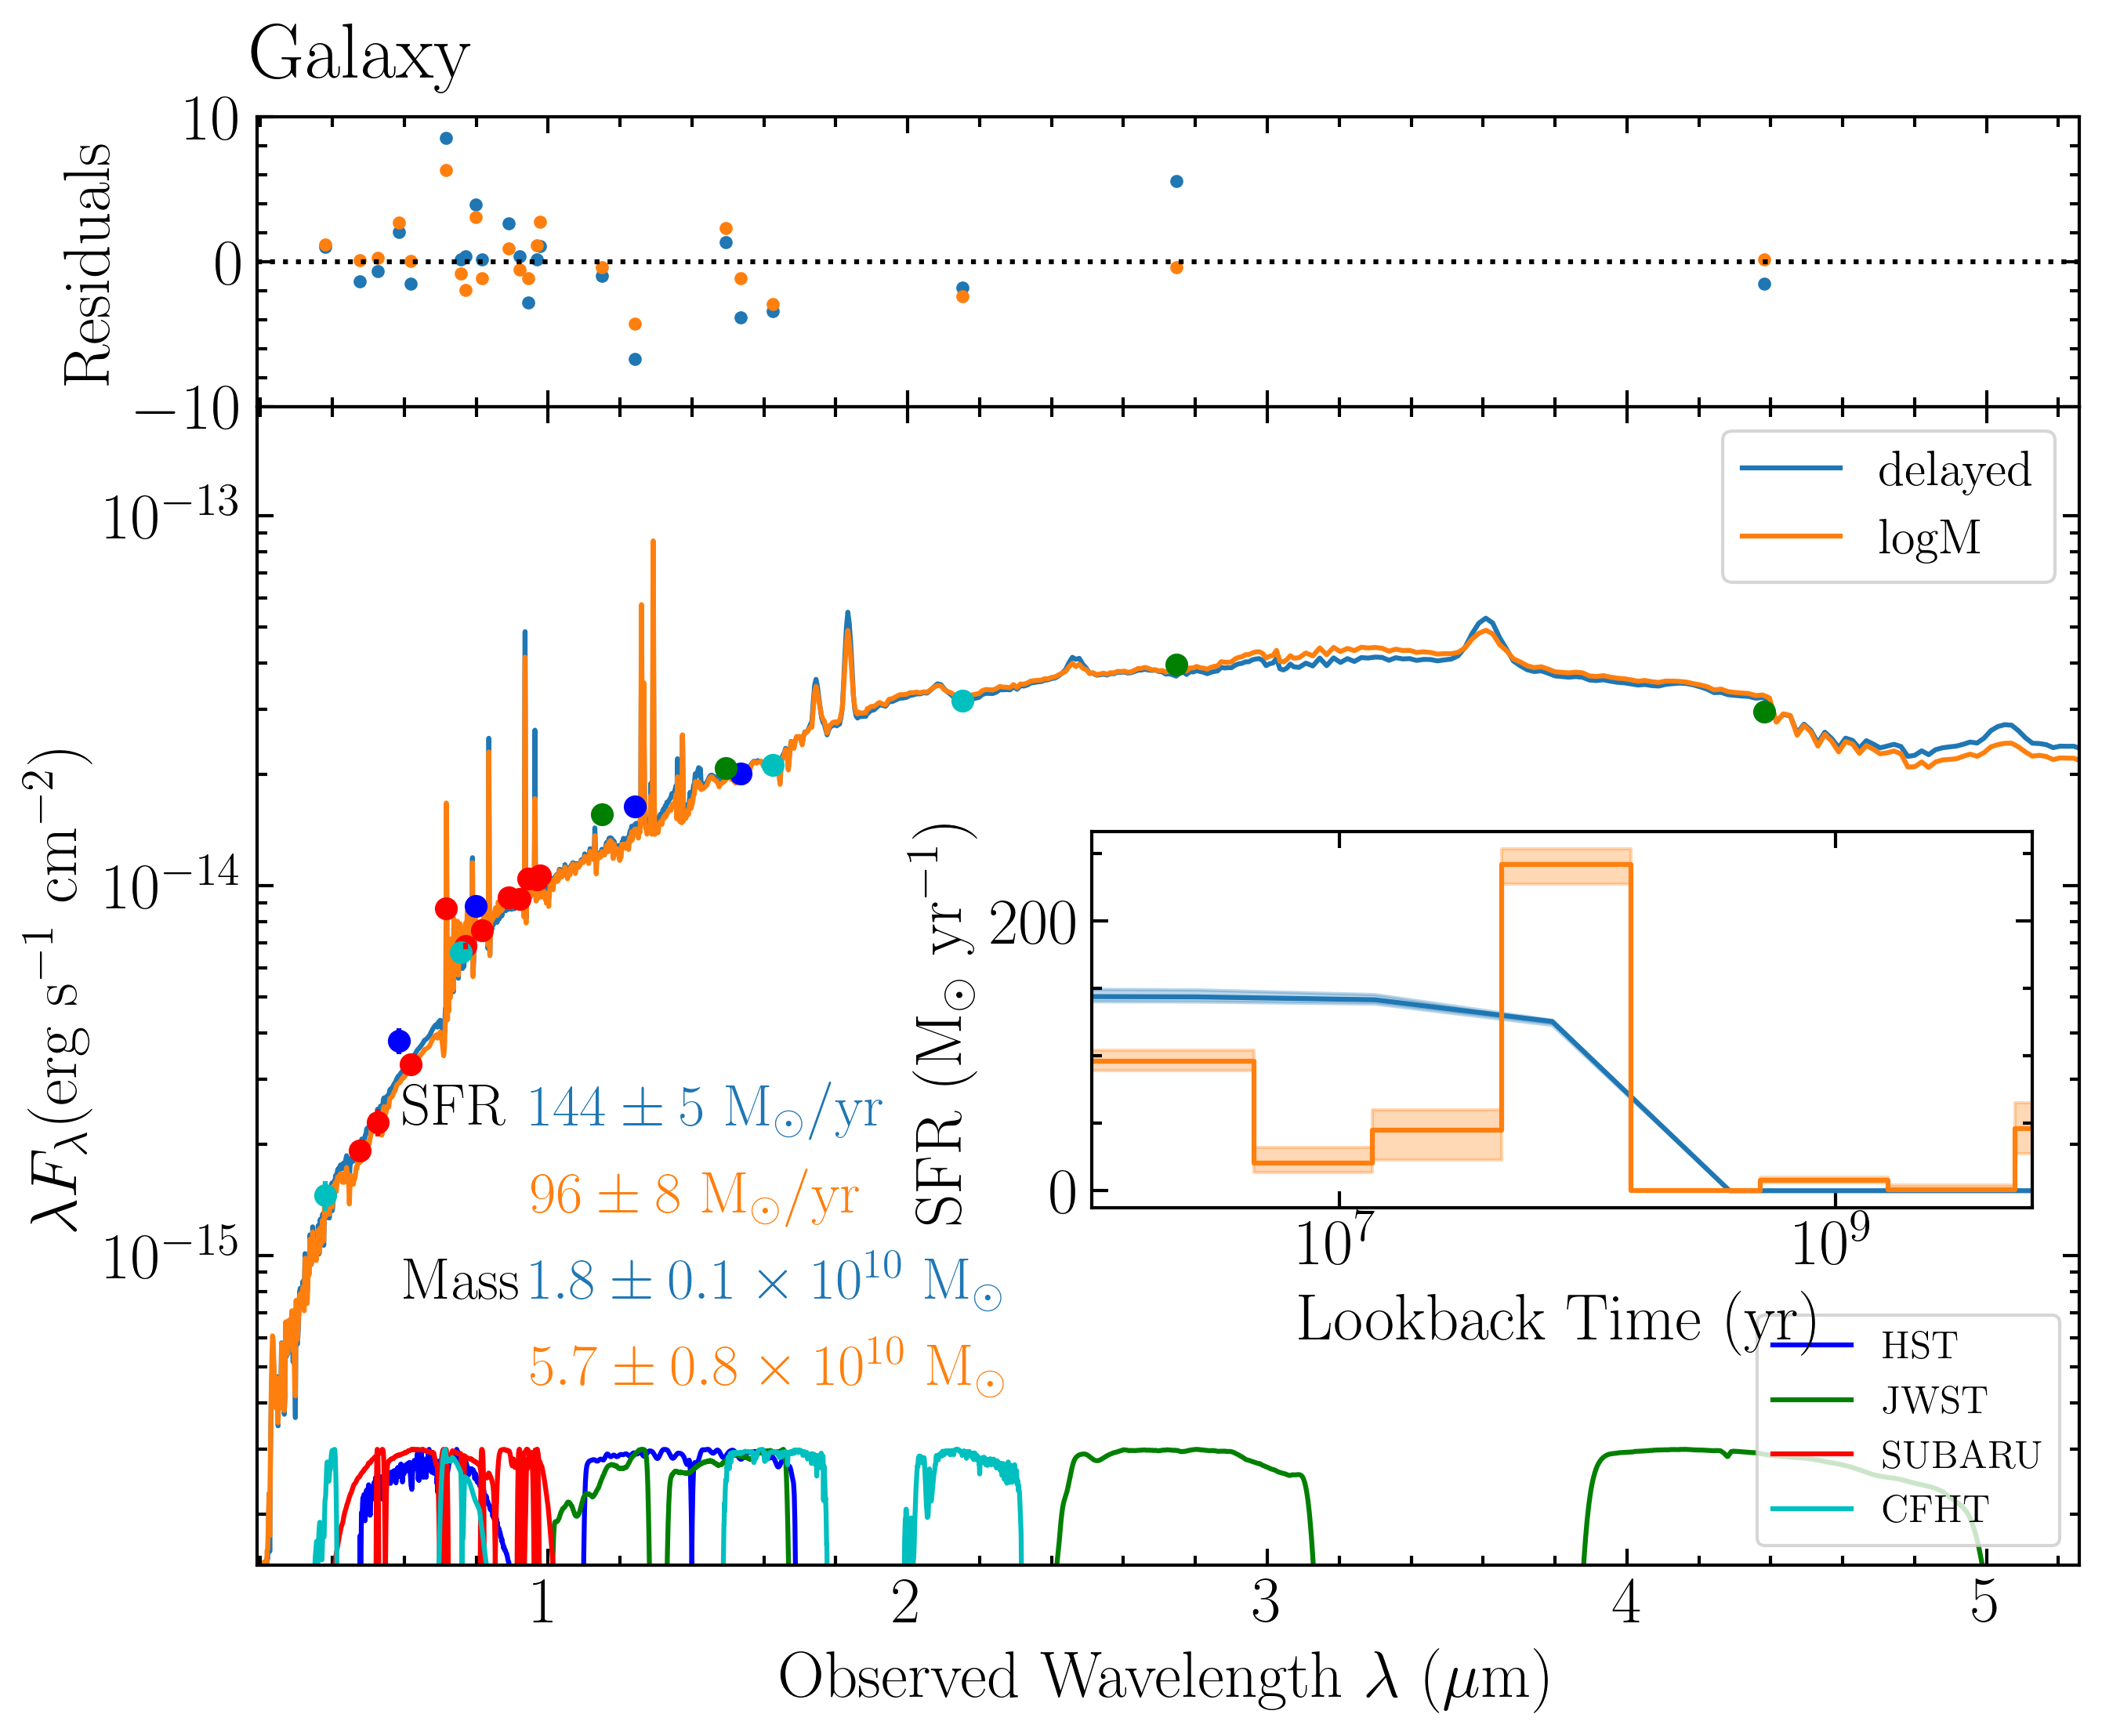

In [36]:
version = 'homo_ellipse_v1_dered'
# SFH_models = ['exponential', 'delayed', 'logM', 'continuity', 'dirichlet']
SFH_models = ['delayed', 'logM']
color_list = list(mcolors.TABLEAU_COLORS.keys())
# color_list.reverse()
nickname = plot_SED_with_SFHs(version, SFH_models, color_list)
plt.suptitle(nickname, x=0.17, y=0.93)
plt.show()

:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=10.0,maxi=1000000000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.6)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=6.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.1,maxi=13.8)
  tau: <class 'prospect.models.priors.TopHat'>(mini=0.3,maxi=10.0)
  gas_logu: <class 'prospect.models.priors.TopHat'>(mini=-5.0,maxi=-1.0)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.924] 
  sfh: [1] 
  imf_type: [2] 
  dust_type: [2] 
  add_neb_emission: [ True] 
  add_neb_continuum: [ True] 
  nebemlineinspec: [ True] 
  gas_logz: [0.] <function stellar_logzsol at 0x7f507b4be050>
:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=10.0,maxi=1000000000000000.0)
  logzsol: 

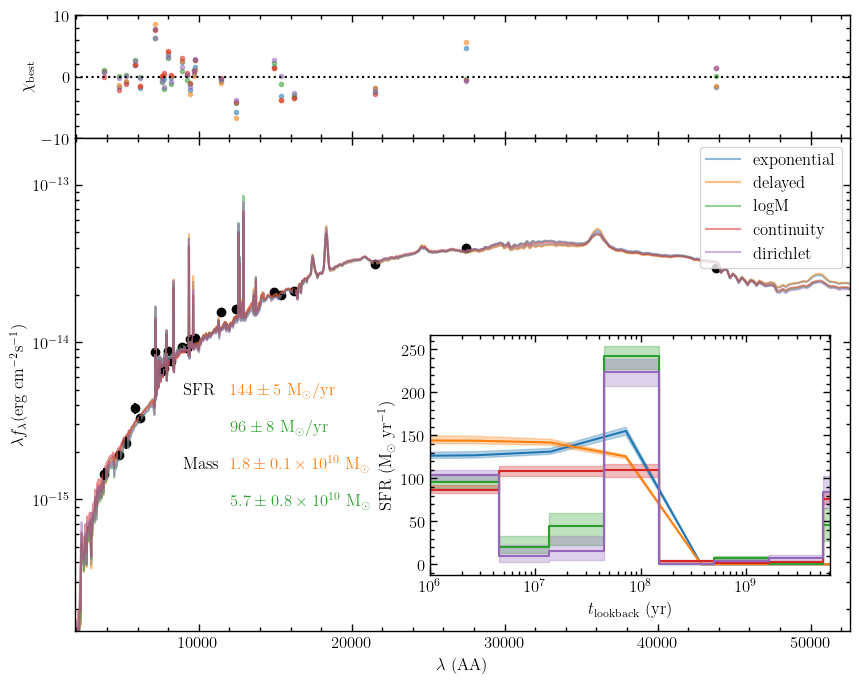

In [68]:
version = 'homo_ellipse_v1_dered'
SFH_models = ['exponential', 'delayed', 'logM', 'continuity', 'dirichlet']
color_list = list(mcolors.TABLEAU_COLORS.keys())
axeslims = plot_SED_with_SFHs(version, SFH_models, color_list)

:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=10.0,maxi=1000000000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.6)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=6.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.1,maxi=13.8)
  tau: <class 'prospect.models.priors.TopHat'>(mini=0.3,maxi=10.0)
  gas_logu: <class 'prospect.models.priors.TopHat'>(mini=-5.0,maxi=-1.0)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.924] 
  sfh: [4] 
  imf_type: [2] 
  dust_type: [2] 
  add_neb_emission: [ True] 
  add_neb_continuum: [ True] 
  nebemlineinspec: [ True] 
  gas_logz: [0.] <function stellar_logzsol at 0x7f8d9372e170>
:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=[100000. 100000. 100000. 100000. 100000. 

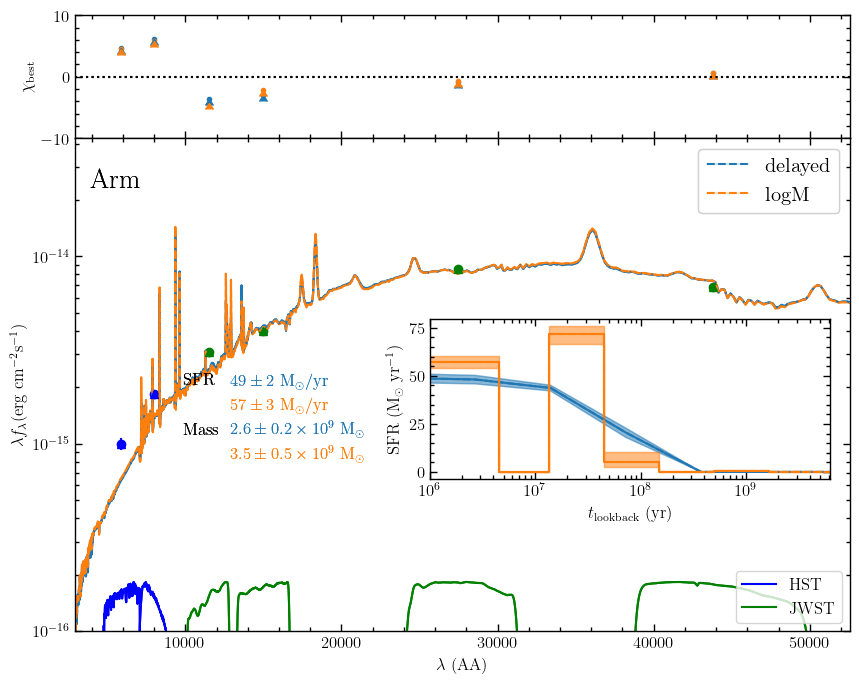

In [38]:
version = 'space_homo_downleft_dered'
# SFH_models = ['exponential', 'delayed', 'logM', 'continuity', 'dirichlet']
# color_list = list(mcolors.TABLEAU_COLORS.keys())
axes = plot_SED_with_SFHs(version, SFH_models, color_list, linestyle='-')

In [33]:
version = 'space_homo_upright_dered'
# SFH_models = ['exponential', 'delayed', 'logM', 'continuity', 'dirichlet']
# color_list = list(mcolors.TABLEAU_COLORS.keys())
axeslims = plot_SED_with_SFHs(version, SFH_models, color_list, axes=axes, linestyle='--', dotstyle=6, marker='^')

:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=10.0,maxi=1000000000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.6)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=6.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.1,maxi=13.8)
  tau: <class 'prospect.models.priors.TopHat'>(mini=0.3,maxi=10.0)
  gas_logu: <class 'prospect.models.priors.TopHat'>(mini=-5.0,maxi=-1.0)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.924] 
  sfh: [4] 
  imf_type: [2] 
  dust_type: [2] 
  add_neb_emission: [ True] 
  add_neb_continuum: [ True] 
  nebemlineinspec: [ True] 
  gas_logz: [0.] <function stellar_logzsol at 0x7f8d9372e170>
:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=[100000. 100000. 100000. 100000. 100000. 

<Figure size 640x480 with 0 Axes>

:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=10.0,maxi=1000000000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.6)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=6.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.1,maxi=13.8)
  tau: <class 'prospect.models.priors.TopHat'>(mini=0.3,maxi=10.0)
  gas_logu: <class 'prospect.models.priors.TopHat'>(mini=-5.0,maxi=-1.0)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.924] 
  sfh: [4] 
  imf_type: [2] 
  dust_type: [2] 
  add_neb_emission: [ True] 
  add_neb_continuum: [ True] 
  nebemlineinspec: [ True] 
  gas_logz: [0.] <function stellar_logzsol at 0x7f41856aa170>
:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=[100000. 100000. 100000. 100000. 100000. 

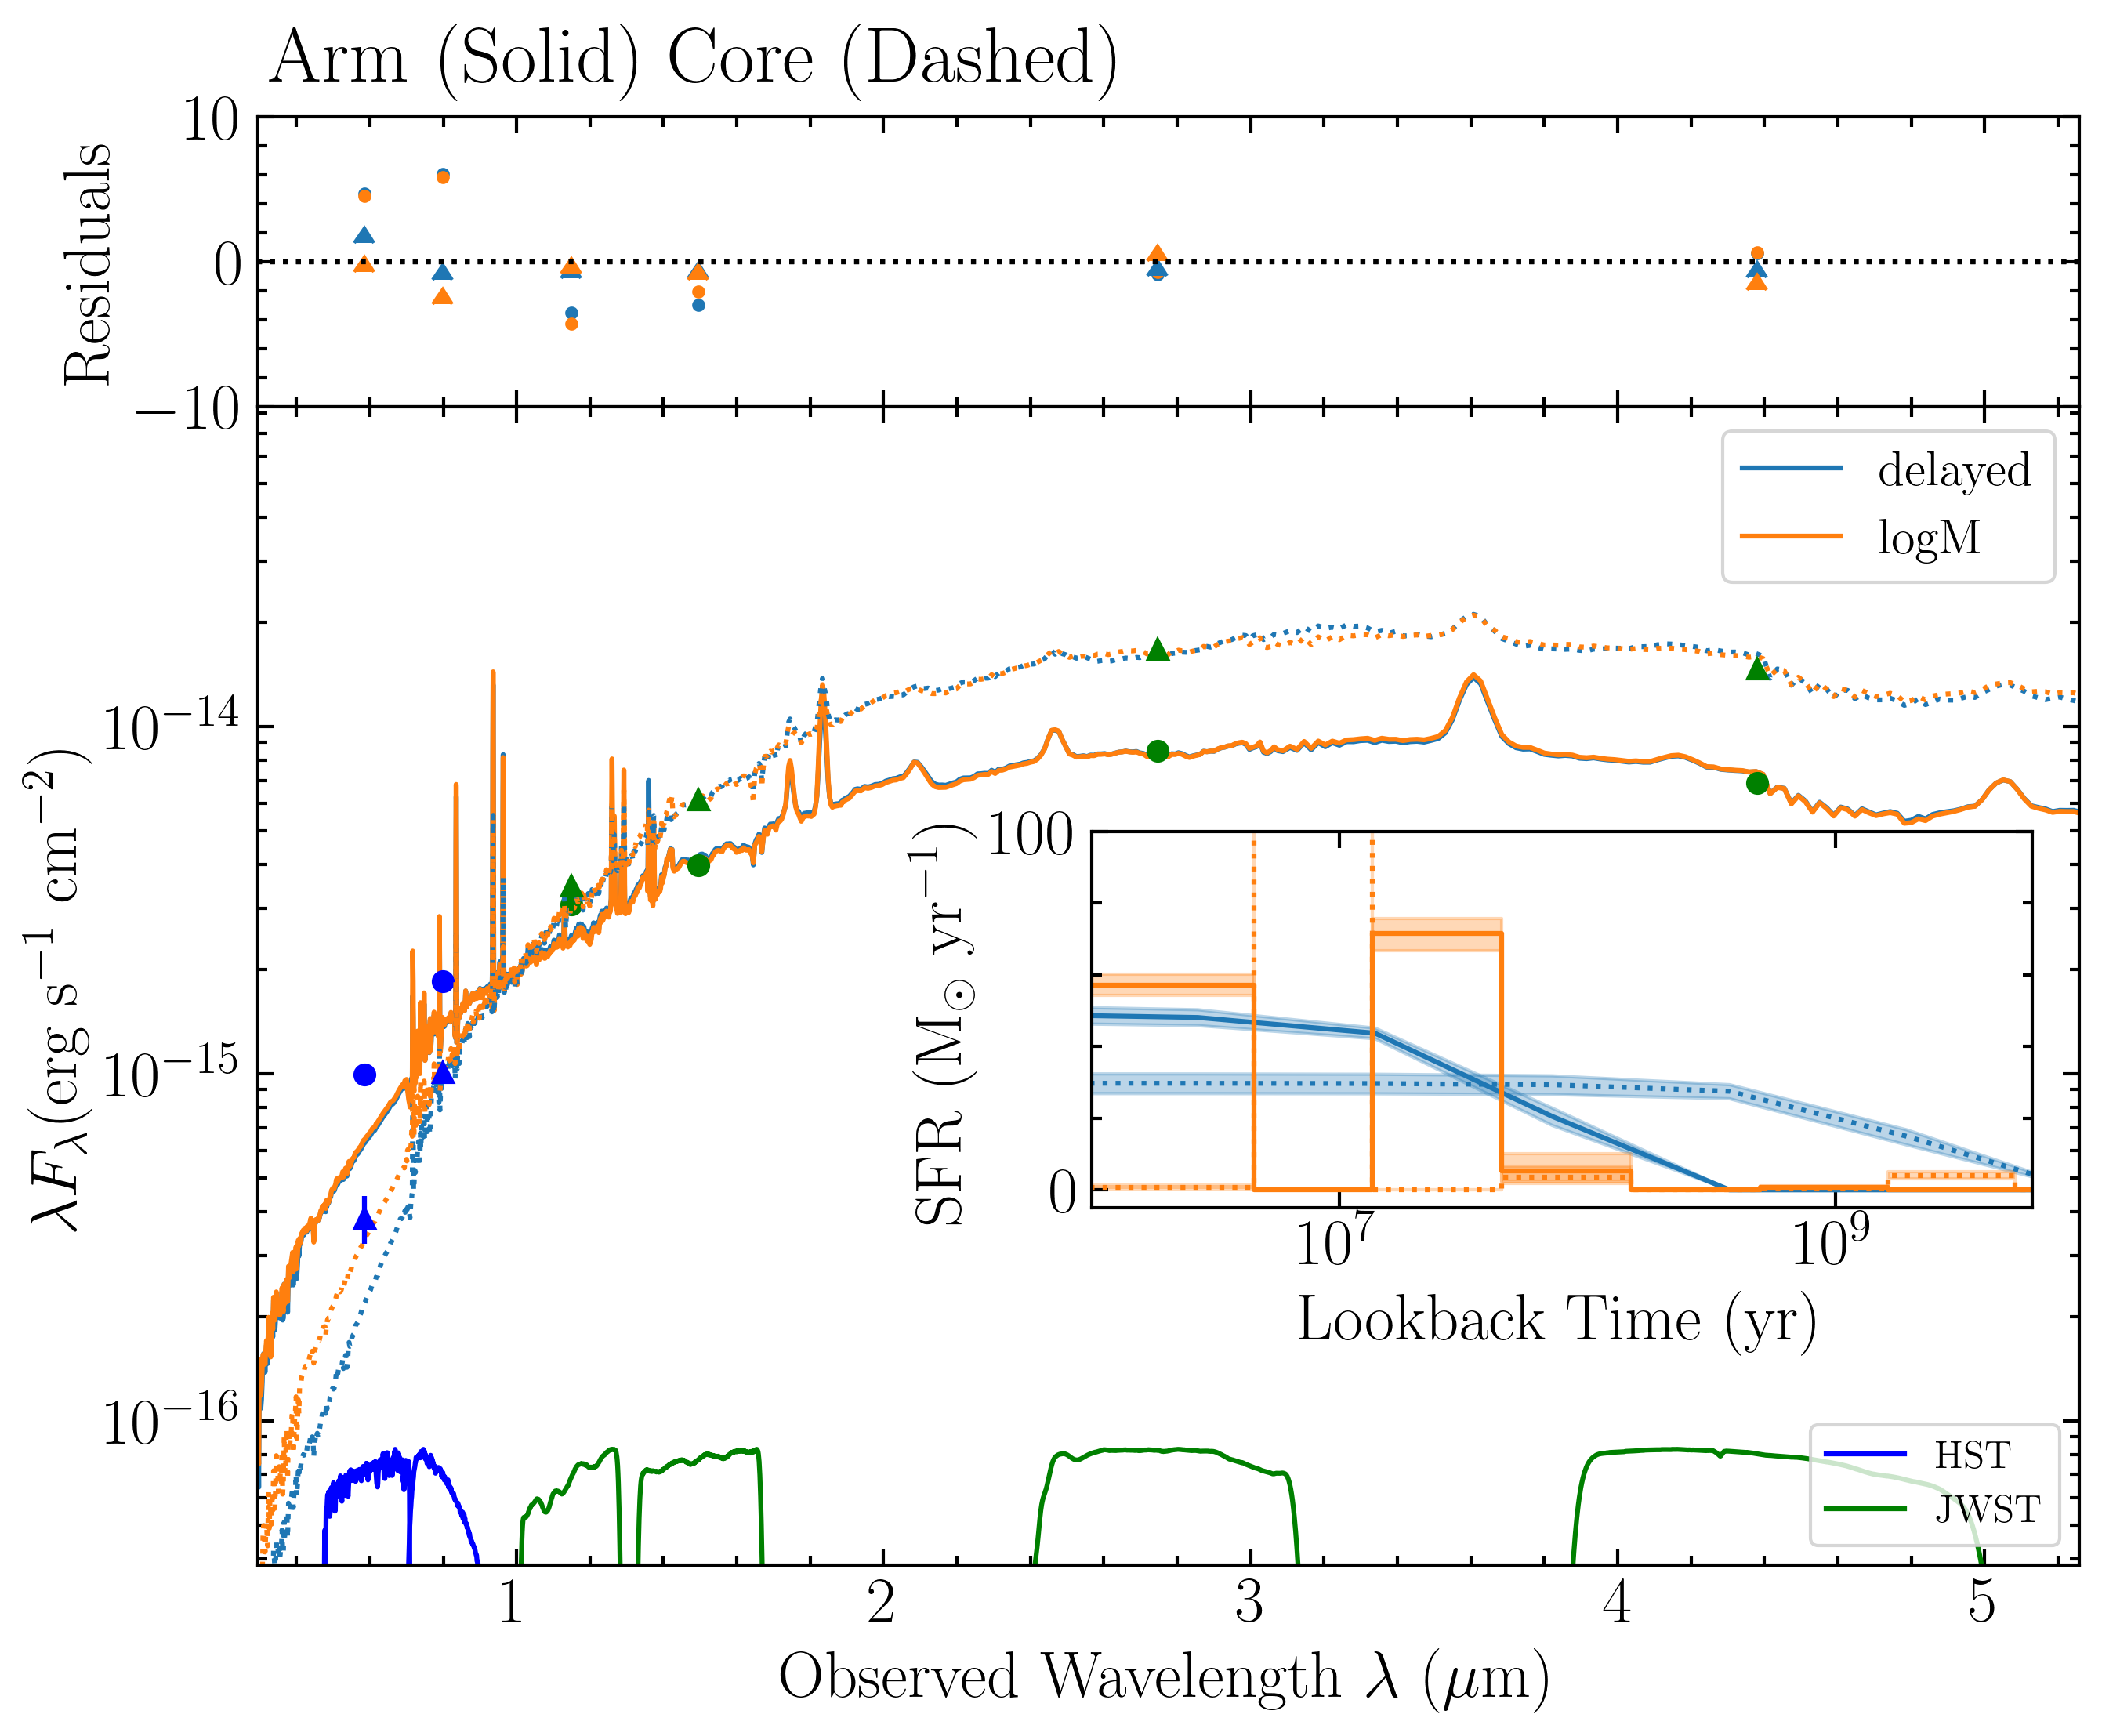

In [34]:
SFH_models = ['delayed', 'logM']
color_list = list(mcolors.TABLEAU_COLORS.keys())
sfig, saxes = plt.subplots(2, 1, gridspec_kw=dict(height_ratios=[1, 4]), sharex=True, figsize=(10, 8))
x, y = 0.48, 0.3
width, height = 0.4, 0.2
subax = sfig.add_axes([x,y,width,height])
nickname1 = plot_SED_with_SFHs('space_homo_downleft_dered', SFH_models, color_list, linestyle='-', axes=(sfig, saxes, subax), add_filter_curve=False, display_results=False, display_legend=True)
nickname2 = plot_SED_with_SFHs('space_homo_upright_dered', SFH_models, color_list, linestyle='dotted', dotstyle=6, marker='^', axes=(sfig, saxes, subax), display_results=False, display_legend=False)
plt.suptitle(nickname1+' '+nickname2, x=0.13, y=0.93, ha='left')
plt.show()

In [23]:
df = pd.read_excel('SED_results_prospect.xlsx', sheet_name='homo_ellipse_v1_dered', index_col=0)

# plot photometry cutouts

In [43]:
source_position = SkyCoord(150.15949, 2.1914772, frame='icrs', unit=u.deg)
z = 0.924
phot = mbp.MultiBandPhotometry(source_position, z,)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set DATE-END to '2016-06-04T00:47:19.488' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-05-03T03:37:16.477' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-06-29T23:52:46.677' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-05-03T03:02:47.823' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-04-30T03:11:04.794' from MJD-END'. [astropy.wcs.wcs]


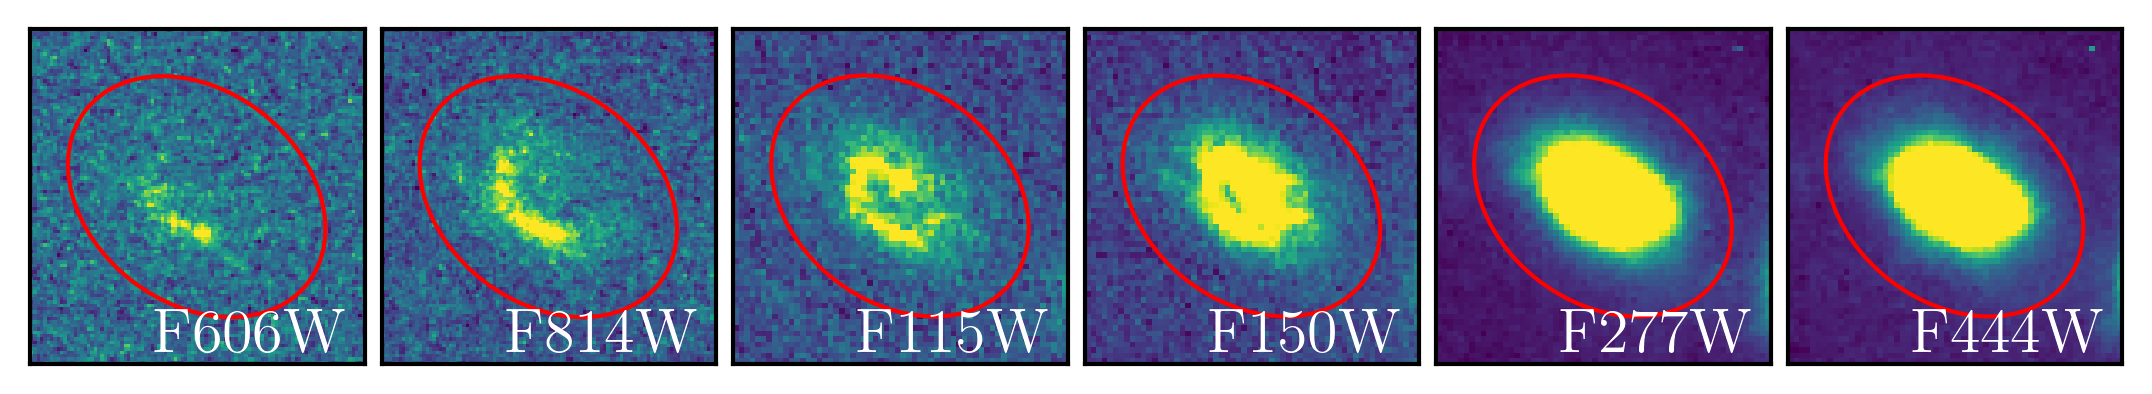

In [71]:
fig, axes = plt.subplots(1, 6, figsize=(9,1.5), squeeze=True)
aperture = phot.load_aperture('ellipse')
telescope_band_list = ['HST_F606W', 'HST_F814W', 'JWST_F115W', 'JWST_F150W', 'JWST_F277W', 'JWST_F444W']
mbp.plotting.plot_cutout_aligned(axes, phot, telescope_band_list, size=3*u.arcsec)
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(wspace=0.05)
plt.show()

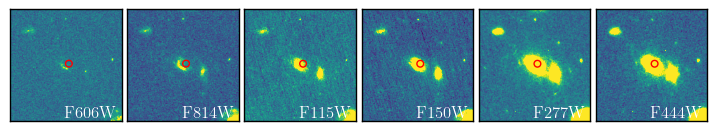

In [7]:
fig, axes = plt.subplots(1, 6, figsize=(9,1.5), squeeze=True)
telescope_band_list = ['HST_F606W', 'HST_F814W', 'JWST_F115W', 'JWST_F150W', 'JWST_F277W', 'JWST_F444W']
mbp.plotting.plot_cutout_aligned(axes, phot, telescope_band_list, aperture_type='upright')
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(wspace=0.05)
plt.show()

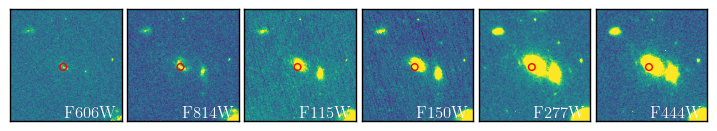

In [8]:
fig, axes = plt.subplots(1, 6, figsize=(9,1.5), squeeze=True)
telescope_band_list = ['HST_F606W', 'HST_F814W', 'JWST_F115W', 'JWST_F150W', 'JWST_F277W', 'JWST_F444W']
mbp.plotting.plot_cutout_aligned(axes, phot, telescope_band_list, aperture_type='downleft')
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(wspace=0.05)
plt.show()

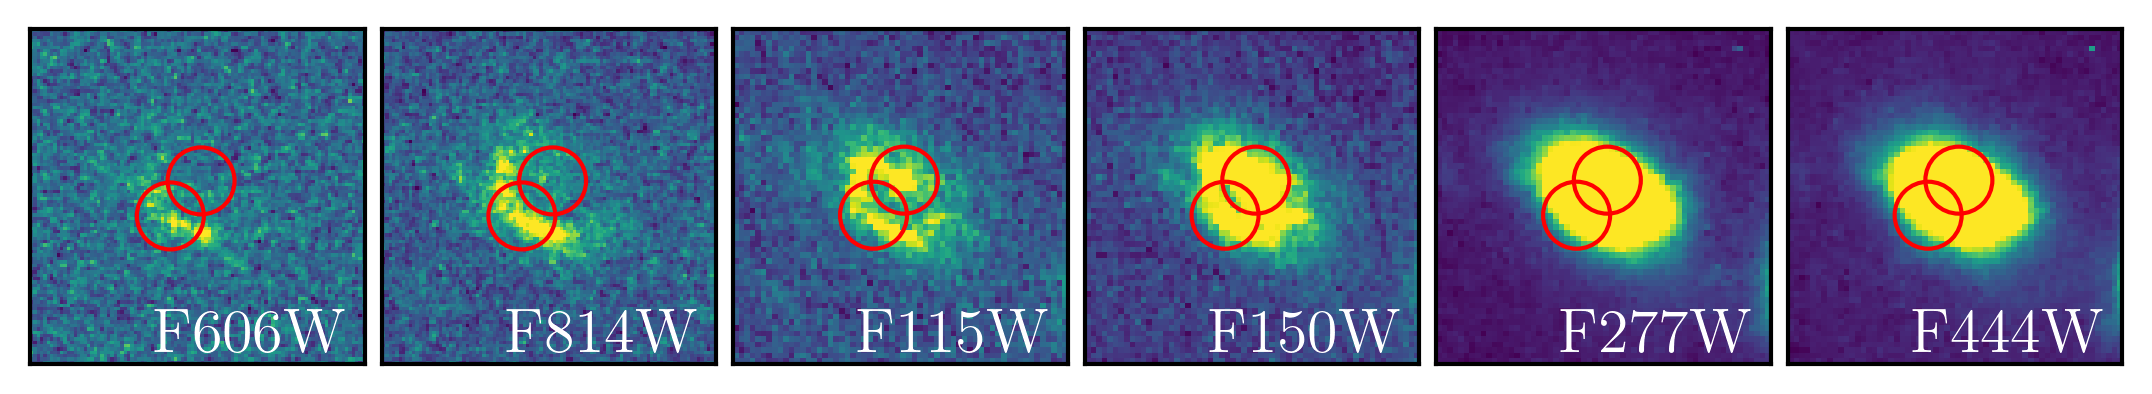

In [47]:
fig, axes = plt.subplots(1, 6, figsize=(9,1.5), squeeze=True)
telescope_band_list = ['HST_F606W', 'HST_F814W', 'JWST_F115W', 'JWST_F150W', 'JWST_F277W', 'JWST_F444W']
mbp.plotting.plot_cutout_aligned(axes, phot, telescope_band_list, aperture_type=('upright-new', 'downleft'), size=3*u.arcsec)
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(wspace=0.05)
plt.show()

# Make redshift PDF

In [56]:
from prospect.io import read_results as reader
hfile = '/home/lupengjun/OII_emitter/SED_fitting/output/prospect_results/homo_nearby_dered_logM.h5'
out, out_obs, out_model = reader.results_from(hfile)

:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  zred: <class 'prospect.models.priors.TopHat'>(mini=0.8,maxi=1.0)
  mass: <class 'prospect.models.priors.LogUniform'>(mini=[100000. 100000. 100000. 100000. 100000. 100000. 100000. 100000.],maxi=[1.e+11 1.e+11 1.e+11 1.e+11 1.e+11 1.e+11 1.e+11 1.e+11])
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.6)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=6.0)
  gas_logu: <class 'prospect.models.priors.TopHat'>(mini=-5.0,maxi=-1.0)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  sfh: [3] 
  imf_type: [2] 
  dust_type: [2] 
  agebins: [[0.         6.65395102]
 [6.65395102 7.13107228]
 [7.13107228 7.65395102]
 [7.65395102 8.17246496]
 [8.17246496 8.69534371]
 [8.69534371 9.21025352]
 [9.21025352 9.72213688]
 [9.72213688 9.79067159]] 
  total_mass: [1.e+10] <function total_mass at 0x7f5960b4fd90>
  add_neb_emission: [ True] 
  add_neb_continuum: [ Tr

In [58]:
out['theta_labels']

['zred',
 'mass_1',
 'mass_2',
 'mass_3',
 'mass_4',
 'mass_5',
 'mass_6',
 'mass_7',
 'mass_8',
 'logzsol',
 'dust2',
 'gas_logu']

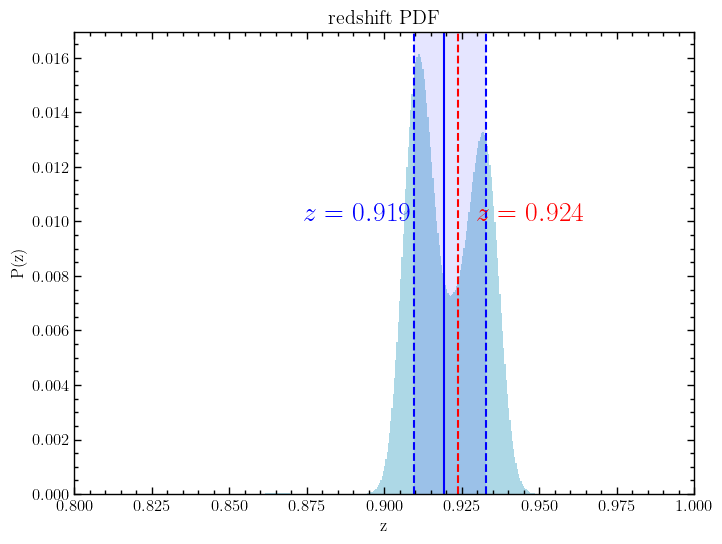

In [60]:
import matplotlib.pyplot as plt
from prospect.plotting import corner
import numpy as np
weights = out['weights']
label_mask = np.atleast_1d(out['theta_labels'])=='zred'
quantile = corner.quantile(out["chain"][:, label_mask].T, [0.16, 0.5, 0.84], weights=weights)
samples_1d = out["chain"][:, label_mask][:, 0]
l, m, u = quantile[0]
fig, ax = plt.subplots(figsize=(8,6))
corner.marginal(samples_1d, ax, weights=weights, span=[0.8, 1.], smooth=0.02,
                 color='lightblue')
ax.set_xlabel('z')
ax.set_ylabel('P(z)')
ax.set_title('redshift PDF')
ymin, ymax = ax.get_ylim()
ax.vlines([0.924], ymin, ymax, color='r', linestyle='--')
ax.vlines([l,u], ymin, ymax, color='b', linestyle='--')
ax.vlines([m], ymin, ymax, color='b', linestyle='-')
ax.fill_betweenx([ymin, ymax], l, u, facecolor='blue', alpha=0.1)
ax.text(0.999*l, 0.01, '$z=%.3f$'%m, ha='right', fontsize=20, color='b')
ax.text(0.93, 0.01, '$z=0.924$', ha='left', fontsize=20, color='r')
plt.savefig('../output/redshift_PDF_logM.png')
plt.show()